# Student's names: 
# - Ahmad Hojatimalekshah
# - Amir Abbas Kazemzadeh Farizhandi
# - Arash Modaresi Rad

## This project has four steps. 

1. We are looking for the most important property of the metallic glasses which is glass transition temperature, $T_{rg}$. Finding this property from experiments is expensive and time consuming. Therefore, a regression model will be proposed to predict $T_{rg}$ from input features (process parameters). 


2. Efficiency of many chemical processes depends on the materials hardness. Because of the complexity of many materials, estimation of hardness is a complicated process. Therefore, a classifier will be developed to predict the range of material hardness from ball milling and fluidization process parameters.   


3. In case we have a mixture matarial with no hardness information, a clustering model can be helpful to estimate its hardness range. Hence, we will develop a clustring model for the data from ball milling and fluidization of pure materials.


4. Particle and material science can help to understand the behavior of biomedical processes. For instance, dry powder inhallers use for many diseases such as athma. In modeling of dry powder inhalation, the particles that reach the target area in respiratory organ will be classified as 1 while other labes are 0. This data is strictly unbalanced and we need to find a way to develop a classifier which can predict the target and particles interaction. 

### Loading packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection,neural_network,ensemble, metrics,datasets
from sklearn.ensemble import AdaBoostClassifier,RandomForestRegressor,RandomForestClassifier
#from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression,LinearRegression,ElasticNet
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN,KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score,silhouette_score,mean_squared_error,r2_score,confusion_matrix
from sklearn.metrics.cluster import homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split , StratifiedKFold,KFold
from sklearn.base import BaseEstimator
from scipy import stats
from sklearn.svm import SVR,SVC
from pylab import *
import statsmodels.api as sm
from scipy import misc
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from itertools import cycle, islice
#import strkernel 
#from strkernel.motifkernel import motifKernel
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import DBSCAN,KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import calibration_curve
from collections import Counter
import itertools
import warnings
warnings.filterwarnings('ignore')

# 1. Regression Problem: Metallic glasses data

### Introduction

During the lab, we’ll be training a machine learning model to predict the reduced glass transition temperature ($T_{rg}$) for metallic glasses. $T_{rg}$ is defined and the ratio of the glass transition temperature ($T_g$) to the liquidus temperature ($T_l$) of the alloy:

$T_{rg}=\frac{T_g}{T_l}$

$T_{rg}$ is an indicator of glass forming ability (GFA) of a given alloy. Alloys with $T_{rg} > 2/3$ are likely to form a metallic glass and are considered to have good GFA. Therefore, if we can build a good model for predicting Trg from composition information of a metallic alloy, we may be able to search material composition space for good glass formers that can be used in a range of materials applications. 


As mentioned earlier our goal is to build a model that reads in a material composition of a potential metallic glass and makes a prediction about the material’s reduced glass transition temperature ($T_{rg}$). To do this, we’ll need a dataset of compositions of various metallic alloys and their corresponding Trg values, which were measured experimentally. 

Before we begin training ML models, it is important to make sure our dataset doesn’t have any obviously bad data that could negatively impact the results. For example, datasets such as these are often automatically generated from databases or scanned from PDF tables. Based on our scientific understanding of Trg, there are a few checks we should do on our $T_{rg}$ values to make sure they are reasonable. First, filter out any values that are negative (since $T_{rg}$ is the ratio of two positive numbers, any negative values are clearly wrong). Second, check for any numbers that are clearly too large. Filter out any values that are greater than 1.

### Loading the data

In [2]:
data = pd.read_csv('D:/VIP-IS/HW/BMG_data_raw.csv',low_memory=False)
data.head()

,formula,PROPERTY: Tl (K),NdValence_composition_average,IsTransitionMetal_composition_average,HeatVaporization_difference,valence_difference,PROPERTY: Trg
0,Ag10Cu20Zr70,NaN,NaN,NaN,NaN,NaN,NaN
1,Ag10Cu25Zr65,NaN,NaN,NaN,NaN,NaN,NaN
2,Ag10Cu35Zr55,1210.869,5.6,1.0,339.87,2.0,0.534391
3,Ag10Cu50Zr40,1150.093,6.8,1.0,339.87,2.0,0.608245
4,Ag10Cu55Zr35,1200.345,7.2,1.0,339.87,2.0,0.608510


In [3]:
data.rename(columns={'PROPERTY: Tl (K)': 'TL','PROPERTY: Trg': 'Trg' }, inplace=True)
data.head()

,formula,TL,NdValence_composition_average,IsTransitionMetal_composition_average,HeatVaporization_difference,valence_difference,Trg
0,Ag10Cu20Zr70,NaN,NaN,NaN,NaN,NaN,NaN
1,Ag10Cu25Zr65,NaN,NaN,NaN,NaN,NaN,NaN
2,Ag10Cu35Zr55,1210.869,5.6,1.0,339.87,2.0,0.534391
3,Ag10Cu50Zr40,1150.093,6.8,1.0,339.87,2.0,0.608245
4,Ag10Cu55Zr35,1200.345,7.2,1.0,339.87,2.0,0.608510


### Data cleaning

In [4]:
data=data.loc[(data['Trg'] >= 0) & (data['Trg'] <= 1)]
data.reset_index(inplace=True)
data.head()

,index,formula,TL,NdValence_composition_average,IsTransitionMetal_composition_average,HeatVaporization_difference,valence_difference,Trg
0,2,Ag10Cu35Zr55,1210.869,5.6,1.0,339.87,2.0,0.534391
1,3,Ag10Cu50Zr40,1150.093,6.8,1.0,339.87,2.0,0.608245
2,4,Ag10Cu55Zr35,1200.345,7.2,1.0,339.87,2.0,0.608510
3,6,Ag15Cu45Zr40,1188.829,6.8,1.0,339.87,2.0,0.586262
4,10,Ag25Cu35Zr40,1220.177,6.8,1.0,339.87,2.0,0.564527


In [5]:
X=data.iloc[:,2:7]
y=data['Trg']
(y=='NaN').unique()

array([False])

### Standardization

In [6]:
sc = StandardScaler()
sc.fit(X)
X_new=sc.transform(X)

### Let's reduce the data dimension

### PCA

In [7]:
pca = PCA().fit(X_new)
pca.explained_variance_ratio_

array([0.65699916, 0.14704294, 0.10798103, 0.06933115, 0.01864572])

#### Based on the explained variance, we will select three principal components:

In [8]:
pca = PCA(n_components=3)
pca.fit(X_new)
X_projected=pca.transform(X_new)

### Let's split the data to train and test

In [9]:
X_split, X_test, y_split, y_test = train_test_split(X_projected, np.array(y), test_size=0.2)

## Running different regression methods

### Polynomial

In [10]:
# number of splits for K-Fold cross validation
n_splits= 5

# Defining a K-Fold cross validation
skf = KFold(n_splits=n_splits,random_state=4,shuffle=True )

# Train and validation data index
ind = list(skf.split(X_split, y_split))

# Empty DataFrame for results
df2 = pd.DataFrame()
for degrees in range(1,5):
    
    # Creating logistic regression fit + l2 regularization
    poly_features = PolynomialFeatures(degree = degrees)
    poly_model = LinearRegression()
        
   # Loop over the folds
    for j in range(0,n_splits):
        # Train and test data for each fold
        X_train = X_split[ind[j][0]]
        y_train = y_split[ind[j][0]]
        X_valid = X_split[ind[j][1]]
        y_valid = y_split[ind[j][1]]
        
        X_poly_train = poly_features.fit_transform(X_train)
        X_poly_valid = poly_features.fit_transform(X_valid)
        # Standardize the train and test data
        sc = StandardScaler()
        X_train_std = sc.fit_transform(X_poly_train)
        X_valid_std = sc.transform(X_poly_valid)
        
        # Fitting the logistic regression
        poly_model.fit(X_train_std, y_train)
        # train and test prediction
        pred_train = poly_model.predict(X_train_std)
        pred_valid = poly_model.predict(X_valid_std)
         
        # Writing the results as a dataframe 
        df1 = pd.DataFrame({'Fold':[j+1],'degrees':[degrees], 'Train Accuracy_r2':[r2_score(y_train, pred_train)],
                            'Validation Accuracy_r2':[r2_score(y_valid, pred_valid)],
                            'Train Accuracy_MSE':[ mean_squared_error(y_train, pred_train)],
                            'Validation Accuracy_MSE':[ mean_squared_error(y_valid, pred_valid)]})
        
        df2 = pd.concat([df1, df2])

#### Let's find the best polynomial degree

Text(0.5, 0, 'Degrees')

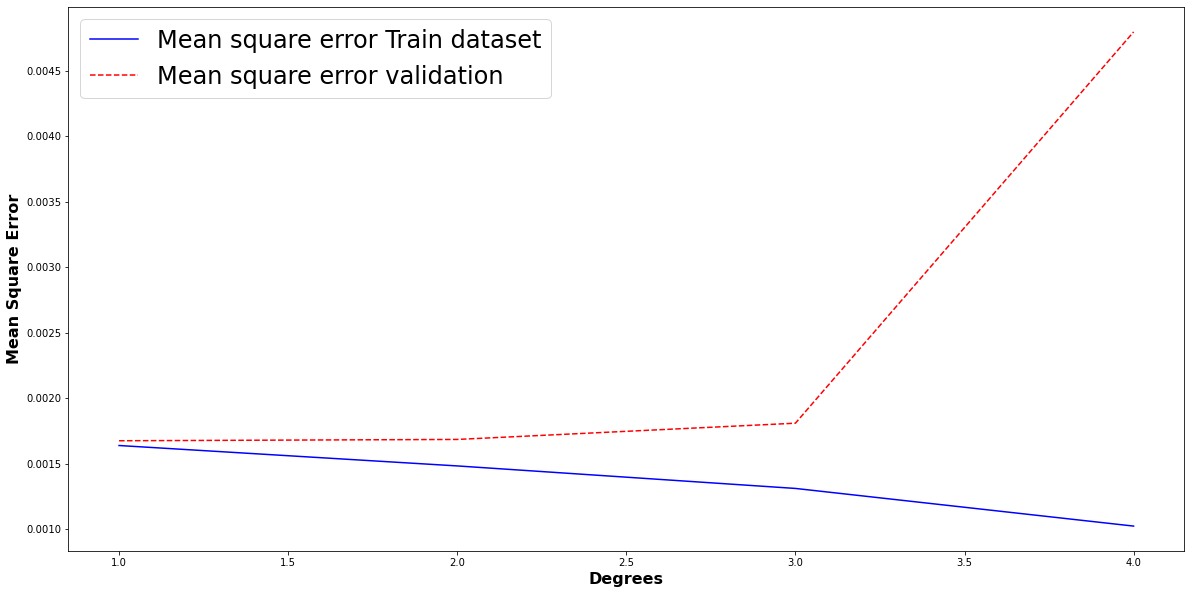

In [11]:
degrees = np.arange(1, 5)
plt.figure(figsize=(20,10))
plt.plot(degrees, df2.groupby(['degrees'])['Train Accuracy_MSE'].mean(), 'b')
plt.plot(degrees, df2.groupby(['degrees'])['Validation Accuracy_MSE'].mean(), '--r')
plt.legend(("Mean square error Train dataset", "Mean square error validation"),fontsize=24)
plt.ylabel('Mean Square Error',weight='bold',fontsize=16)
plt.xlabel('Degrees',weight='bold',fontsize=16)

#### The best polynomial model degree is 3.

### Defining evaluation function

In [12]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

### Random Forest

In [13]:
kfold = model_selection.KFold(n_splits=5, random_state=10)
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2)

### Let's find the best parameters of random forest model by grid search

In [14]:
# Fit the grid search to the data
grid_search.fit(X_split, y_split)
grid_search.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.7min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

### Accuracy of the best random forest model on test data

In [15]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 0.0190 degrees.
Accuracy = 96.51%.


### Support Vector Machine

In [16]:
param_grid = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'degree':[1,2,3,4,5],'kernel': ['poly']},
              {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}]

# Create a based model
supportr = SVR()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = supportr, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2)

### Let's find the best parameters of Support Vector Machine model by grid search

In [17]:
grid_search.fit(X_split, y_split)
grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 52 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:    1.8s finished


{'C': 1000, 'degree': 1, 'gamma': 0.0001, 'kernel': 'poly'}

### Accuracy of the best Support Vector Machine model on test data

In [18]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 0.0343 degrees.
Accuracy = 93.86%.


### Neural Network

In [19]:
parameters = {'solver': ['lbfgs'], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':np.arange(5, 12), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
grid_search = GridSearchCV(neural_network.MLPRegressor(), parameters, n_jobs=-1,cv=kfold)

### Let's find the best parameters of Neural Network model by grid search

In [20]:
grid_search.fit(X_split, y_split)
grid_search.best_params_

{'alpha': 0.1,
 'hidden_layer_sizes': 10,
 'max_iter': 500,
 'random_state': 0,
 'solver': 'lbfgs'}

### Accuracy of the best Neural Network model on test data

In [21]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 0.0229 degrees.
Accuracy = 95.87%.


### ElasticNet

In [22]:
parameters = {'l1_ratio': [0.0001,0.001,0.1,0.5,1], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(1, 7), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
grid_search = GridSearchCV(ElasticNet(), parameters, n_jobs=-1,cv=kfold)

### Let's find the best parameters of ElasticNet model by grid search

In [23]:
grid_search.fit(X_split, y_split)
grid_search.best_params_

{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 500, 'random_state': 0}

### Accuracy of the best ElasticNet model on test data

In [24]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 0.0281 degrees.
Accuracy = 94.84%.


### Gradient Boosting

In [25]:
param_grid={'n_estimators':[100,500,1000], 
            'learning_rate': [0.1,0.05,0.02,0.01,0.001],
            'max_depth':[5,10,20], 
            'min_samples_leaf':[2,3,4,5,6]} 
grid_search = GridSearchCV(ensemble.GradientBoostingRegressor(), param_grid, n_jobs=-1,cv=kfold)

### Let's find the best parameters of Gradient Boosting model by grid search

In [26]:
grid_search.fit(X_split, y_split)
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 20,
 'min_samples_leaf': 5,
 'n_estimators': 1000}

### Accuracy of the best Gradient Boosting model on test data

In [27]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 0.0177 degrees.
Accuracy = 96.82%.


# 2. Classification: 
### Evaluation of material hardness using planetary ball milling for modeling the change of particle size distribution in a gas-solid fluidized bed

### Introduction

The pure material hardness ranges between 1 and 9 based on Mohs unit. The ball milling and fluidization data from three pure materials with different Mohs hardness (Graphite: 1,  Gypsum: 4.5, and Silica: 7) has been provided by experiments. Different classifiers will be developed to predict the range of material hardness from ball milling and fluidization process parameters.  

### Loading dataset

In [28]:
data = pd.read_csv('data_particles.csv',low_memory=False)
data.head()

,time (min),velocity (m/s),d0,n0,d,n,B d,Bn
0,30,0.8,0.90621,1.811,0.863994,1.437510,0.06517,0.07185
1,60,0.8,0.90621,1.811,0.847785,1.365092,0.06517,0.07185
2,120,0.8,0.90621,1.811,0.838540,1.344356,0.06517,0.07185
3,180,0.8,0.90621,1.811,0.836219,1.338721,0.06517,0.07185
4,240,0.8,0.90621,1.811,0.834874,1.333641,0.06517,0.07185


### Features and labels

In [29]:
X=np.array(data.iloc[:,0:6])
y=np.array(data['B d'])
y[y==0.06517]=0
y[y==0.5875]=1
y[y==0.18360]=2

### Spliting the dataset

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Examining different classification method and finding the optimum parameters for each model

In [31]:
names = ["Nearest Neighbors", "SVM Poly", "SVM RBF", "SVM sigmoid", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]

tuned_parameters = [{'n_neighbors':(np.arange(1,11,1))},
                    { 'C':(np.arange(0.1,1000,10)) ,'degree': [2,3,4] ,'gamma':[0.0001,0.001,0.01,0.02,0.03,0.04,0.05],'kernel':['poly']},
                    {'C': (np.arange(0.1,1000,10)) , 'gamma': [0.0001,0.001,0.01,0.02,0.03,0.04,0.05], 'kernel': ['rbf']},
                    {'C': (np.arange(0.1,1000,10)),'gamma': [0.0001,0.001,0.01,0.02,0.03,0.04,0.05],'kernel':['sigmoid']},
                    {'kernel':[1.0 * RBF(1.0)],'multi_class':['one_vs_rest','one_vs_one']},
                    {'max_depth':(np.arange(1,101,1)),'min_samples_split':[2,3]},
                    {'max_depth':(np.arange(1,101,1)),'min_samples_split':[2,3]},
                    {'hidden_layer_sizes':(np.arange(10,100,10)),'alpha':[0.0001,0.001,0.1,1],'max_iter':[100,1000]},
                    {'n_estimators':[10,50,100],'learning_rate':[0.1,1,10]}]


classifiers = [
    KNeighborsClassifier(),
    SVC(),
    SVC(),
    SVC(),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier()]


X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)
i=0

    # iterate over classifiers
for name, clf in zip(names, classifiers):
    #clf.fit(X_train_std, y_train)
    model = GridSearchCV(clf, tuned_parameters[i],cv=10,scoring='accuracy')
    model.fit(X_train_std, y_train)
    y_pred= model.predict(X_test_std)
    print(name)
    print('Best parameters:',model.best_params_)
    print('Test accuracy:',accuracy_score(y_pred,y_test))
    
    #score = clf.score(X_test_std, y_test)
    #print('score for model',name,'is',score)
    print('--------------------------------------------------------------')
    i+=1

Nearest Neighbors
Best parameters: {'n_neighbors': 2}
Test accuracy: 0.9768518518518519
--------------------------------------------------------------
SVM Poly
Best parameters: {'C': 580.1, 'degree': 2, 'gamma': 0.05, 'kernel': 'poly'}
Test accuracy: 0.9444444444444444
--------------------------------------------------------------
SVM RBF
Best parameters: {'C': 560.1, 'gamma': 0.02, 'kernel': 'rbf'}
Test accuracy: 0.9953703703703703
--------------------------------------------------------------
SVM sigmoid
Best parameters: {'C': 250.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
Test accuracy: 0.9120370370370371
--------------------------------------------------------------
Gaussian Process
Best parameters: {'kernel': 1**2 * RBF(length_scale=1), 'multi_class': 'one_vs_rest'}
Test accuracy: 0.9907407407407407
--------------------------------------------------------------
Decision Tree
Best parameters: {'max_depth': 70, 'min_samples_split': 3}
Test accuracy: 0.9305555555555556
------------------

### Evaluation of best model with optimum parameters with test dataset

In [32]:
opt_kernel = 'rbf'
opt_degree = 0
opt_C=560.1
opt_gamma = 0.02 
X_train_std = sc.fit_transform(X_train)
opt_clf=SVC( C=opt_C,kernel = opt_kernel, gamma= opt_gamma)#,degree=opt_degree)
opt_clf.fit(X_train_std, y_train)
print('The train set accuracy with optimum parameters:',opt_clf.score(X_train_std, y_train))
X_test_std = sc.fit_transform(X_test)
print('The test set accuracy with optimum parameters:',opt_clf.score(X_test_std, y_test))

The train set accuracy with optimum parameters: 0.9988425925925926
The test set accuracy with optimum parameters: 0.9953703703703703


# 3. Clustering: 
### Let's see if we can apply clustering to separate the elements in the blended materials based on their properties (hardness)

### Data illustration

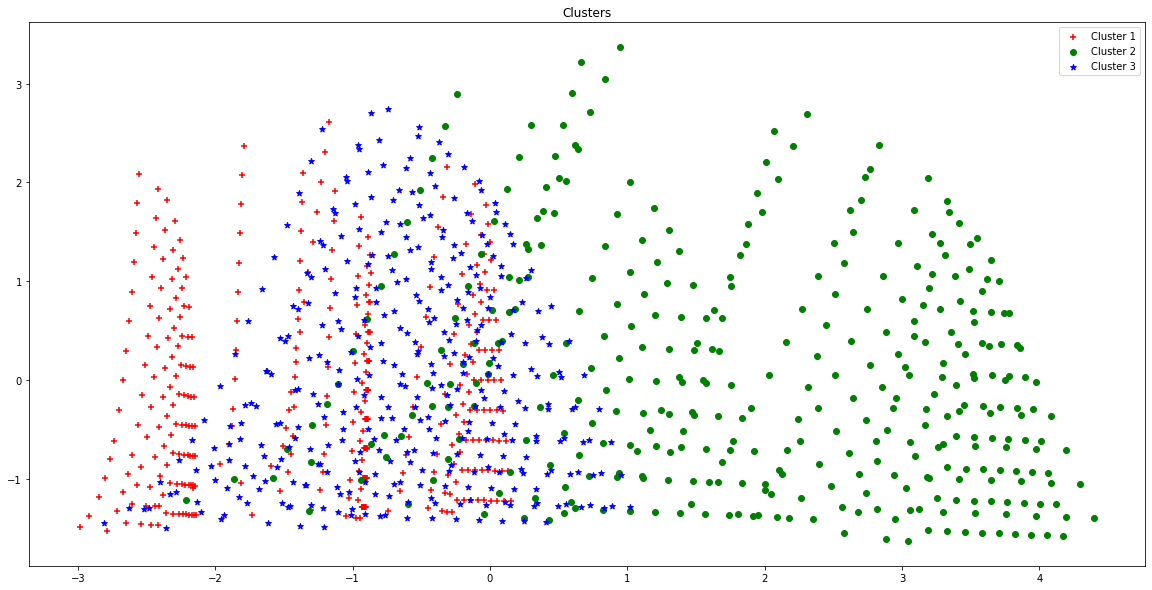

In [33]:
X_std = sc.transform(X)
pca=PCA(n_components=3).fit(X_std)
pca_2d=pca.transform(X_std)
plt.figure(figsize=(20,10))
for i in range(0, pca_2d.shape[0]):
    if y[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif y[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif y[i] == 2:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('Clusters')
plt.show()

### KMeans

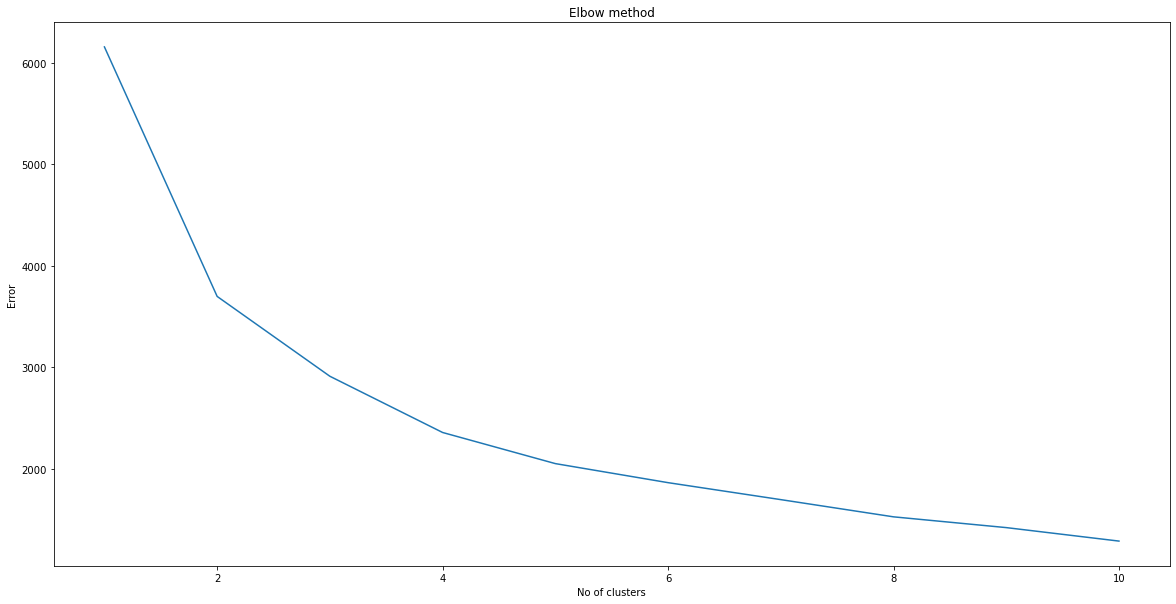

In [34]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X_std)
    kmeans.fit(X_std)
    Error.append(kmeans.inertia_)
plt.figure(figsize=(20,10))
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

#### According to elbow mwthod, the k=3 can be good estimation for number of clusters.

### Evaluation of KMeans clustering with k=3

In [35]:
kmeans3 = KMeans(n_clusters=3)
labels = kmeans3.fit_predict(X_std)
print("Homogeneity: %0.3f" % homogeneity_score(y, labels))
print("Completeness: %0.3f" % completeness_score(y, labels))
print("V-measure: %0.3f" % v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"% adjusted_mutual_info_score(y, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_std, labels))

Homogeneity: 0.319
Completeness: 0.350
V-measure: 0.334
Adjusted Rand Index: 0.208
Adjusted Mutual Information: 0.333
Silhouette Coefficient: 0.309


### DBSCAN

In [36]:
dbscan=DBSCAN()
db=dbscan.fit(X_std)
labels = db.labels_
print("Homogeneity: %0.3f" % homogeneity_score(y, labels))
print("Completeness: %0.3f" % completeness_score(y, labels))
print("V-measure: %0.3f" % v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"% adjusted_mutual_info_score(y, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_std, labels))

Homogeneity: 0.656
Completeness: 0.348
V-measure: 0.455
Adjusted Rand Index: 0.252
Adjusted Mutual Information: 0.452
Silhouette Coefficient: 0.143


### Gaussian Mixture Model

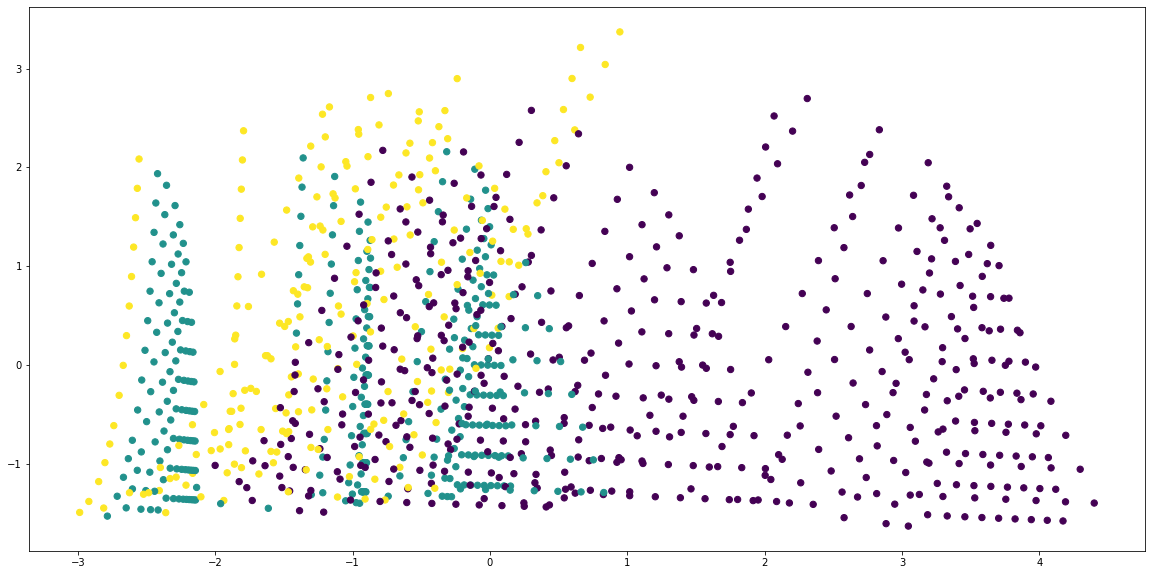

In [37]:
gmm = GaussianMixture(n_components=3).fit(X_std)
labels = gmm.predict(X_std)
plt.figure(figsize=(20,10))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=labels, s=40, cmap='viridis');

#### The results show that Gaussian Mixture Model can find the clusters accurately. 

# 4. Unbalanced dataset: 
### If most of training data belongs to one material, we will have unbalanced dataset problem.

### Introduction

Particle and material science can help to understand the behavior of biomedical processes. For instance, dry powder inhallers use for many diseases such as athma. In modeling of dry powder inhalation, the particles that reach the target area in respiratory organ will be classified as 1 while other labes are 0. This data is strictly unbalanced and we need to find a way to develop a classifier which can predict the target and particles interaction.

### Loading dataset

In [38]:
df_data=pd.read_csv('DPI_data.csv')
df_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Counting the labels

In [39]:
y=df_data['Class']
counter = Counter(y)
print(counter)

Counter({0: 284315, 1: 492})


### Dummy model accuracy (the model that can predict 0 for all the labels)

In [40]:
284315/(492+284315)

0.9982725143693799

### Definition a function for plotting confusion matrix

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
def classification_setup(df_data):
    '''Returns X_data, y_data, ls_features'''
    X_data, y_data = df_data, df_data['Class']
    ls_features = list(X_data.keys())
    class_index = ls_features.index('Class')
    ls_features.pop(class_index)
    return X_data, y_data, ls_features

X_data, y_data, ls_features = classification_setup(df_data)

#### To compare the models without and with undersampling, first we will develop a Adaboost model without undersampling 

### Adaboost model with no undersampling

In [42]:
def adaboost_no_undersample(X_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)
    dt_clf = DecisionTreeClassifier(max_depth = 1)
    ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                  learning_rate = 0.1, 
                                  n_estimators = 100)
    ada_real.fit(X_train[ls_features], y_train)
    y_pred_train = ada_real.predict(X_train[ls_features])
    y_pred_test = ada_real.predict(X_test[ls_features])
    train_conf = confusion_matrix(y_train, y_pred_train)
    test_conf = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title('Train dataset',fontsize=25)
    plot_confusion_matrix(train_conf, title='Confusion matrix train', classes = ['Non Effective particle', 'Effective particle'])
    
    plt.subplot(1, 2, 2)
    plt.title('Test dataset',fontsize=25)
    plot_confusion_matrix(test_conf, title='Confusion matrix test',classes = ['Non Effective particle', 'Effective particle'])
    print('The accuracy for train dataset is:',accuracy_score(y_pred_train,y_train))
    print('The recall for train dataset is:',recall_score(y_train,y_pred_train))
    print('The accuracy for test dataset is:',accuracy_score(y_pred_test,y_test))
    print('The recall for test dataset is:',recall_score(y_test,y_pred_test))

Confusion matrix, without normalization
Confusion matrix, without normalization
The accuracy for train dataset is: 0.9992649984785
The recall for train dataset is: 0.6639566395663956
The accuracy for test dataset is: 0.999115193393444
The recall for test dataset is: 0.5934959349593496


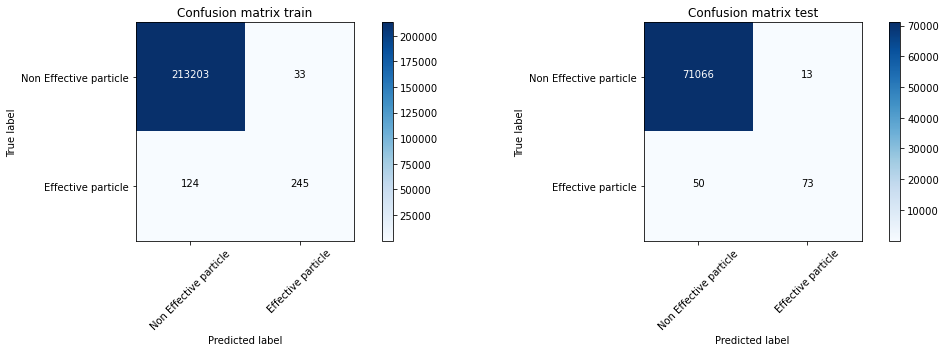

In [43]:
adaboost_no_undersample(X_data, y_data)

### Adaboost model with undersampling

In [44]:
def under_sample_kfold(X_data, y_data, n_folds = 10):
    
    pos_events = X_data[X_data['Class'] == 1]
    neg_events = X_data[X_data['Class'] == 0]
    
    #Randomize and pick same n number of events
    number_pos_events = len(pos_events)  
    undersampled_folds = []

    for fold in range(0, n_folds):
        pos_events = pos_events.reindex(np.random.permutation(pos_events.index))
        neg_events = neg_events.reindex(np.random.permutation(neg_events.index))
        undersampled_events = pd.concat([neg_events.head(number_pos_events), pos_events])
        X_data_u, y_data_u = undersampled_events, undersampled_events['Class']
        X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_data_u, y_data_u, test_size=0.3)
        undersampled_folds.append([X_train_u, X_test_u, y_train_u, y_test_u])
    return undersampled_folds


folds = under_sample_kfold(X_data, y_data)

In [45]:
def adaboost_undersample(folds, full_test_set = False):
    
    for fold in folds:
        X_train, X_test, y_train, y_test = fold[0], fold[1], fold[2], fold[3]
    
        dt_clf = DecisionTreeClassifier(max_depth = 1)
        ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                      learning_rate = 0.1, 
                                      n_estimators = 100)
        ada_real.fit(X_train[ls_features], y_train)

        if full_test_set == False:
            y_pred = ada_real.predict(X_test[ls_features])
            test_conf = confusion_matrix(y_test, y_pred)
            plot_confusion_matrix(test_conf, classes = ['Non Effective particle', 'Effective particle'])
    
        else:
            X_train_and_test = pd.concat([X_train, X_data])
            X_test_full = (X_train_and_test.reset_index()
                                           .drop_duplicates(subset= 'index', keep= False)
                                           .set_index('index'))
            y_test_full = X_test_full['Class']
        
            #Eval
            y_pred = ada_real.predict(X_test_full[ls_features])
            test_conf = confusion_matrix(y_test_full, y_pred)
            #print('The accuracy for train dataset is:',accuracy_score(y_pred_train,y_train))
            #print('The recall for train dataset is:',recall_score(y_train,y_pred_train))
            print('The accuracy for dataset is:',accuracy_score(y_pred,y_test_full))
            print('The recall for dataset is:',recall_score(y_test_full,y_pred))
            plt.figure(figsize=(15,5))
            plot_confusion_matrix(test_conf, classes = ['Non Effective particle', 'Effective particle'])

The accuracy for dataset is: 0.9774671880444462
The recall for dataset is: 0.9230769230769231
Confusion matrix, without normalization


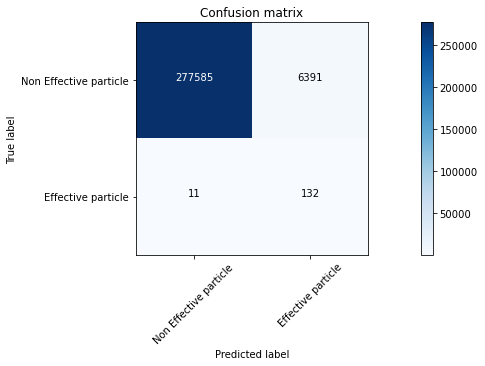

In [46]:
adaboost_undersample([folds[0]], full_test_set = True)

### Ensembled model with undersampling

In [47]:
def cv_setup(X_data, y_data):
    pos_events = X_data[X_data['Class'] == 1]
    neg_events = X_data[X_data['Class'] == 0]
    number_pos_events, number_neg_events, number_events = (len(pos_events), 
                                                           len(neg_events),
                                                           len(X_data))
    pos_events = pos_events.reindex(np.random.permutation(pos_events.index))
    neg_events = neg_events.reindex(np.random.permutation(neg_events.index))
    X_cv = pd.concat([neg_events.tail(number_neg_events//10), 
                      pos_events.tail(number_pos_events//10)])
    y_cv = X_cv['Class']

    #Get rid of duplicates between CV and Test/Train bank of data
    X_data = pd.concat([X_cv, X_data])
    X_data = (X_data.reset_index()
                    .drop_duplicates(subset= 'index', keep= False)
                    .set_index('index'))
    y_data = X_data['Class']
    
    return X_data, y_data, X_cv, y_cv, ls_features

In [48]:
#Remake our folds without including 10% of the data for a CV set
X_data, y_data, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
folds = under_sample_kfold(X_data, y_data)

The accuracy for test dataset is: 0.9817766853932585
The recall for test dataset is: 0.8775510204081632
Confusion matrix, without normalization


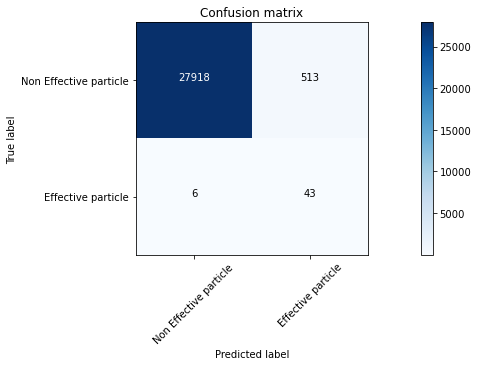

In [49]:
def adaboost_undersample_ensemble(folds):
    
    X_train_all_folds = pd.DataFrame()
    ada_ensemble = []
    
    for fold in folds:
        X_train, X_test, y_train, y_test = fold[0], fold[1], fold[2], fold[3]
    
        dt_clf = DecisionTreeClassifier(max_depth = 1)
        ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                      learning_rate = 0.1, 
                                      n_estimators = 100)
        ada_real.fit(X_train[ls_features], y_train)
        #Concatenate all train sets and store each fold models
        X_train_all_folds = pd.concat([X_train_all_folds, X_train])
        ada_ensemble.append(ada_real)
    
    #Call scorer
    ensemble_score(X_cv, y_cv, ada_ensemble)

def ensemble_score(X_test, y_test, models, cutoff = 0.5, e_cutoff = 5):    
    for fold in range(0, len(models)):
        X_test.loc[:, ('Prob fold ' + str(fold))] = models[fold].predict_proba(X_test[ls_features])[:,1]
        X_test.loc[:, ('ADAPred fold ' + str(fold))] = (X_test[('Prob fold ' + str(fold))] >= cutoff).astype(int)
    
    X_test.loc[:, 'Ensemble Score'] = X_test[['ADAPred fold ' + str(i) for i in range(0, len(models))]].sum(axis = 1)
    X_test.loc[:, 'Ensemble Pred'] = (X_test['Ensemble Score'] > e_cutoff).astype(int)

    y_pred_test=X_test[('Ensemble Pred')]
    ensemble_conf = confusion_matrix(y_test,y_pred_test )
    print('The accuracy for test dataset is:',accuracy_score(y_pred_test,y_test))
    print('The recall for test dataset is:',recall_score(y_test,y_pred_test))
    plt.figure(figsize=(15,5))
    plot_confusion_matrix(ensemble_conf, classes = ['Non Effective particle', 'Effective particle'])

adaboost_undersample_ensemble(folds)

#### The number of effective particles is the most important parameters in dry powder inhalation process, we are looking for to predict them with high accuracy. Therefore, recall can give us the best criteria for model accuracy. According to results, recall improves with undersapling.

# References
1. https://scikit-learn.org/stable/supervised_learning.html
2. https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn
3. https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
4. https://scikit-learn.org/stable/modules/clustering.html
5. https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
6. https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets